# 코드 실행해주세요

In [1]:
from hyperopt import STATUS_OK, fmin, tpe, Trials, hp
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156 )

X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

# 1번
베이지안 하이퍼파리미터 최적화하고 XGBoost 알고리즘 사용해보기

(1) 검색 공간 사용[5점]

<조건> hyperopt 사용해주세요
1. max_depth : 1 ~ 10 (step = 1)
2. learning_rate : 0.02 ~ 0.3 (step은 안씁니다.)

In [2]:
xgb_search_space = {'max_depth' : hp.quniform('max_depth', 1, 10, 1),
                    'learning_rate' : hp.uniform('learning_rate', 0.02, 0.3)}

(2) 목적 함수 생성[10점]

<조건>
1. n_estimators : 300
2. 검색 공간 사용해서 하이퍼파라미터 넣어주기
3. binary classification에 적합한 eval_metric을 써주세요.
4. None값을 채워주시고, 채워주신 값에 대한 이유를 주석으로 적어주세요

In [3]:
def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators = 300,
                            max_depth = int(search_space['max_depth']),
                            learning_rate = search_space['learning_rate'])
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)
    return {'loss': -1 * np.mean(accuracy), 'status': STATUS_OK} 
# Hyper Opt의 목적 함수는 최솟값을 반환할 수 있도록 최적화해야 되기 때문에 정확도처럼 값이 클수록 좋은 성능 지표의 경우 -1을
# 곱한 뒤 반환하여 더 큰 성능지표가 더 작은 반환값이 되도록 설정해줘야 함. 그래서 -1을 곱함.

(3) 베이지안 최적화 사용 [5점]

<조건>

1.fmin() 클래스를 이용해서 각 인자의 알맞은 값을 써주시고, 최적화된 learning_rate와 max_depth를 출력해주세요.

2. algo = tpe.suggest 사용해주세요.
3. seed값은 9로 설정해주세요.
4. 평가횟수는 100번으로 설정해주세요.

In [4]:
trial_val = Trials()
best = fmin(fn = objective_func,
            space = xgb_search_space,
            algo = tpe.suggest,
            max_evals = 100,
            trials = trial_val,
            rstate = np.random.default_rng(seed = 9))
print('best:', best)

100%|█████████████████████████████████████████████| 100/100 [00:52<00:00,  1.92trial/s, best loss: -0.9736406413384455]
best: {'learning_rate': 0.19360649319258083, 'max_depth': 1.0}


In [5]:
# best max_depth : 1.0 / best learning_rate : 약 0.1936

In [6]:
best['learning_rate']

0.19360649319258083

# (4) 산점도를 통한 그래프 이해 [10점]

max_depth와 learning_rate에 따른 loss(accuracy)값 변화 산점도로 살펴보기(matplotlib만 사용해주세요.)

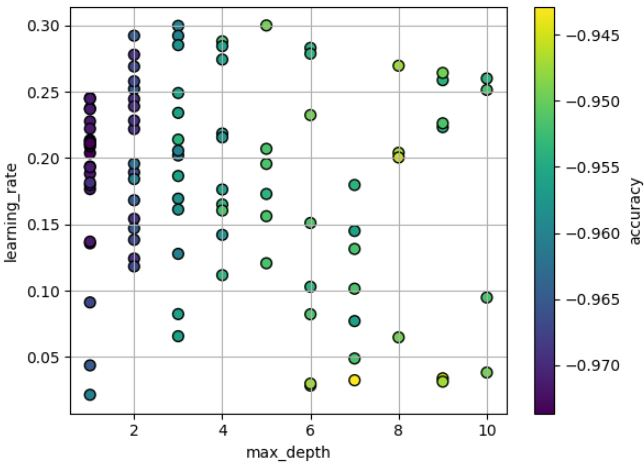

보기와 같은 그래프에 알맞게 코드 짜주시면 됩니다. 분포도는 다를 수 있습니다.(accuarcy에 -를 곱한 값이 더 정확한 그래프이지만, 감안하고 그래프 생성해주시면 됩니다.)

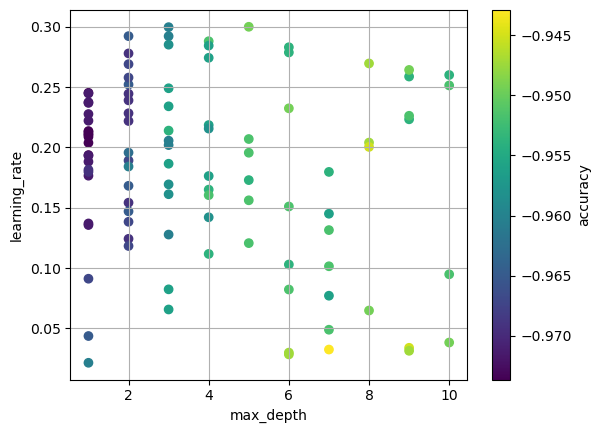

In [7]:
losses = [loss_dict['loss'] for loss_dict in trial_val.results]

result_df = pd.DataFrame({'x' : trial_val.vals['learning_rate'], 'y' : trial_val.vals['max_depth'], 'losses' : losses})
plt.scatter(x = result_df.y, y = result_df.x, c = result_df.losses)
plt.grid()
plt.colorbar(label = 'accuracy')
plt.xlabel('max_depth')
plt.ylabel('learning_rate')
plt.show()

# (5) 최적의 하이퍼파리미터로 학습하기

<조건>
1. 위에서 찾은 최적의 하이퍼파라미터 값으로 설정해주세요.
2. eval_set는 훈련데이터와 검증 데이터로 설정해주세요.
3. 조기 중단은 10번으로 설정해주세요.
4. binary classification에 맞는 loss함수를 설정해주세요.


In [8]:
xgb_wrapper = XGBClassifier(n_estimators = 300,
                            max_depth = int(best['max_depth']),
                            learning_rate = best['learning_rate'])

evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds = 10,
                eval_metric = 'logloss', eval_set = evals, verbose = True)
# 47번째에서 0.25969로 가장 좋은 점수가 나와서 10번 더 돌리고 조기중단

[0]	validation_0-logloss:0.56473	validation_1-logloss:0.59857
[1]	validation_0-logloss:0.47093	validation_1-logloss:0.52803
[2]	validation_0-logloss:0.40123	validation_1-logloss:0.48345
[3]	validation_0-logloss:0.34509	validation_1-logloss:0.44030
[4]	validation_0-logloss:0.30361	validation_1-logloss:0.40358
[5]	validation_0-logloss:0.26906	validation_1-logloss:0.37949
[6]	validation_0-logloss:0.24141	validation_1-logloss:0.36829
[7]	validation_0-logloss:0.21843	validation_1-logloss:0.35585
[8]	validation_0-logloss:0.20003	validation_1-logloss:0.33639
[9]	validation_0-logloss:0.18454	validation_1-logloss:0.33599
[10]	validation_0-logloss:0.17145	validation_1-logloss:0.33583
[11]	validation_0-logloss:0.16026	validation_1-logloss:0.33909
[12]	validation_0-logloss:0.15077	validation_1-logloss:0.32777
[13]	validation_0-logloss:0.14197	validation_1-logloss:0.31834
[14]	validation_0-logloss:0.13452	validation_1-logloss:0.32193
[15]	validation_0-logloss:0.12806	validation_1-logloss:0.31216
[1

C:\Users\82109\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\82109\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.19360649319258083,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

#(6)  학습 데이터 손실함수와 검증 데이터의 손실함수를 비교[20점]

<조건>
1.위의 산점도 그래프처럼 matplotlib으로만 그래프 그려주세요.

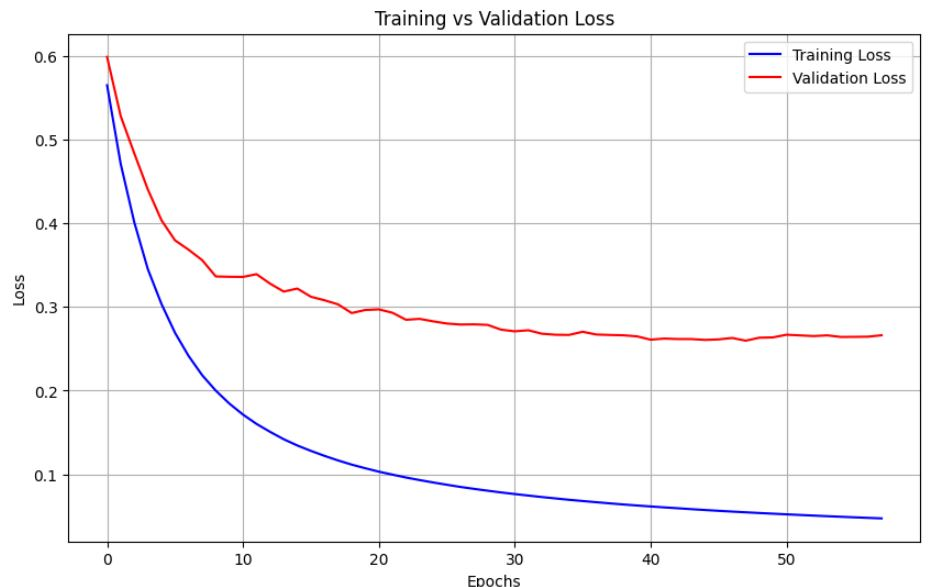

위와 같은 그래프로 코드 짜주시면 됩니다. (loss값은 다를 수 있으므로 그래프와 똑같이 출력이 안될 수 있습니다.)


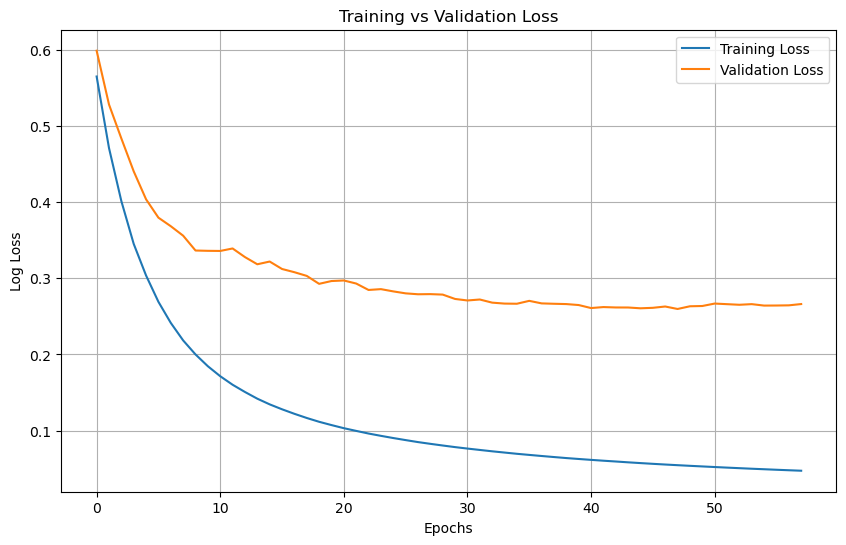

In [9]:
# 학습 및 검증 데이터에 대한 손실 기록
results = xgb_wrapper.evals_result()

# 손실 그래프 그리기
train_losses = results['validation_0']['logloss']
val_losses = results['validation_1']['logloss']

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

# 2번

Stacking과 Voting

# 코드 실행해주세요.

In [10]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
import numpy as np

mnist = fetch_openml(name = 'mnist_784')

X_features, y_labels = mnist.data, mnist.target

C:\Users\82109\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


#(1) MNIST 데이터 분할[5점]

<조건>

1.MNIST 데이터는 이미지 데이터로, 총 70000장입니다.
훈련 : 50,000장
검증 : 10,000장
테스트 : 10,000장
으로 각각 분할해주세요.

2. 훈련,검증,테스트 label데이터는 0.2 비율로 맞춰주세요.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=10000, random_state = 0)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 10000, random_state = 0)

In [12]:
X_tr.shape, X_val.shape, X_test.shape

((50000, 784), (10000, 784), (10000, 784))

# (2)로지스틱 회귀, k-최근접 이웃, 랜덤포레스트 인스턴스 생성해주세요.[5점]

<조건>
1. 하이퍼파리미터는 마음대로 설정해주세요.

In [13]:
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier()
rf_clf = RandomForestClassifier()

# (3) 위에서 생성한 분류기로 voting방법을 사용해서 앙상블로 연결해보시고, 테스트 세트로 확인해보세요.
# 각 분류기와 비교해서 성능이 얼마나 향상되는지 주석으로 말씀해주세요. [15점]

<조건>
1. 각 분류기마다 정확도를 출력해주셔야합니다.
2. voting과 각 분류기마다 정확도를 비교해주세요.
3. 각 분류기와 비교해서 성능이 얼마나 향상되는지 주석으로 말씀해주세요.(코드로도 작성 가능합니다.)


In [14]:
lr_clf.fit(X_tr, y_tr)
lr_pred = lr_clf.predict(X_test)
print('lr 정확도:{0:.4f}'.format(accuracy_score(y_test, lr_pred)))

knn_clf.fit(X_tr, y_tr)
knn_pred = knn_clf.predict(X_test)
print('knn 정확도:{0:.4f}'.format(accuracy_score(y_test, knn_pred)))

rf_clf.fit(X_tr, y_tr)
rf_pred = rf_clf.predict(X_test)
print('rf 정확도:{0:.4f}'.format(accuracy_score(y_test, rf_pred)))

vo_clf = VotingClassifier(estimators = [('LR', lr_clf), ('KNN', knn_clf), ('RF', rf_clf)], voting = 'soft')
vo_clf.fit(X_tr, y_tr)
vo_pred = vo_clf.predict(X_test)
print('vt 정확도:{0:.4f}'.format(accuracy_score(y_test, vo_pred)))

C:\Users\82109\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


lr 정확도:0.9160


AttributeError: 'Flags' object has no attribute 'c_contiguous'

# (4)문제의 각 분류기를 실행해서 검증 세트에서 예측을 만들고 그 결과로 새로운 훈련 세트를 만들어보세요. 각 훈련 샘플은 하나의 이미지에 대한 전체 분류기의 예측을 담은 벡터고 타깃은 이미지의 클래스입니다. 새로운 훈련 세트에 분류기 하나를 훈련시켜 보세요.[15점]


<조건>

1.RandomForest로 문제에서 주어질 것 입니다.

In [ ]:



rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)


# (5) 생성한 훈련세트로 rnd_forest_blender를 학습시켜주세요.[5점]


# (6) 이제 블렌더(메타 모델)을 훈련시켰으니, 테스트 세트에 앙상블을 평가해보고 정확도를 출력해주세요.[5점]



------

# 3번

## 1. 데이터 전처리 (10점)

In [52]:
# Environment setting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
%matplotlib inline

(1) creditcard.csv 파일을 'card_df'라는 이름의 데이터프레임으로 읽어주세요 -1점

In [53]:
card_df = pd.read_csv('creditcard.csv')

(2) card_df의 각 컬럼들에 대하여 결측치와 dtype을 확인해주세요 - 2점

In [54]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

(3) 본 실습의 목적은 주어진 컬럼들로 'Class (정상거래 or 사기거래)'를 예측하는 것입니다. 위 데이터의 'Class' 컬럼의 분포를 확인하고, 각 클래스가 어떤 거래를 의미하는지 적어주세요. - 2점

In [55]:
# 'Class' 컬럼 분포 확인
card_df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

답) 0 : 정상거래 / 1 : 사기거래

(4) card_df에서 class 예측에 필요없는 컬럼인 'Time' 컬럼을 삭제해주세요. - 2점

In [56]:
card_df.drop(columns = 'Time', inplace = True)

(5) label 데이터와 feature 데이터로 나눈 후, 학습과 테스트 데이터로 분할해주세요. (단, test_size = 0.3,random_state=0, 클래스 0과 1의 분포가 학습 및 데스트 데이터에 동일하도록 분할) - 3점

In [57]:
feature = card_df.iloc[:, :-1]
label = card_df.iloc[:, -1]

In [58]:
X_train, X_test, y_train, y_test=train_test_split(feature, label, test_size=0.3, random_state=0)

In [59]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((199364, 29), (85443, 29), (199364,), (85443,))

## 2. 하이퍼 파라미터 튜닝(45점)

베이지안 최적화를 기반으로 하는 HyperOpt를 사용한 하이퍼 파라미터 튜닝은 다음의 단계를 거친다.<br>
1. 검색 공간 설정<br>
2. 목적 함수 설정<br>
3. 최적의 파라미터 추출<br>
4. 최적의 파라미터로 학습 및 평가<br><br>
위 순서로 과제를 진행해보자.

### 0. 다음의 코드를 실행해 주세요.

In [60]:
!pip install lightgbm==3.3.2

In [64]:
!pip show lightgbm

Name: lightgbm
Version: 3.3.2
Summary: LightGBM Python Package
Home-page: https://github.com/microsoft/LightGBM
Author: 
Author-email: 
License: The MIT License (Microsoft)
Location: C:\Users\82109\anaconda3\Lib\site-packages
Requires: numpy, scikit-learn, scipy, wheel
Required-by: 


In [61]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [65]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

lgbm_clf = LGBMClassifier(n_estimators=1000, early_stopping_rounds=300)

eval_set=[(X_tr, y_tr), (X_val, y_val)]
lgbm_clf.fit(X_tr, y_tr, eval_metric="auc", eval_set=eval_set, verbose = False)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))


TypeError: LGBMClassifier.fit() got an unexpected keyword argument 'verbose'

위 코드를 통해 튜닝 전 ROC AUC가 0.8919임을 알 수 있다.(문제 1에서 확인했듯이 레이블의 분포가 불균형하므로 모든 평가 지표는 accuracy가 아닌 ROC AUC를 사용한다.)

### 1. 검색 공간을 설정해보자(10점).<br>
HyperOpt의 hp 모듈은 입력값의 검색 공간을 다양하게 설정할 수 있도록 여러 함수를 제공한다.(책 257쪽 참고)<br>
LightGBM의 경우 주로 num_leaves, max_depth, min_childe_samples를 통해 하이퍼 파라미터를 튜닝한다.<br>
< 과제 ><br>
a.num_leaves: 64부터 128까지 1의 간격을 가지고 설정<br>
b.max_depth: 128부터 256까지 1의 간격을 가지고 설정<br>
c.min_child_samples: 64부터 128까지 2의 간격을 가지고 설정<br>
d.learning_rate: 0.1부터 0.2까지 로그 변환된 값이 정규 분포 형태를 가지도록 설정

In [41]:
from hyperopt import hp
lgbm_search_space = {'num_leaves': hp.quniform('num_leaves', 64, 128, 1),
                     'max_depth': hp.quniform('max_depth', 128, 256, 1),
                     'min_child_samples': hp.quniform('min_child_samples', 64, 128, 2),
                     'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2)
                    }

### 2. 목적함수를 설정해보자(10점).<br>
탐색 시간을 줄이기 위해 목적함수의 모델에서는 n_estimator을 200으로 줄인다.<br>
< 과제 ><br>
a.n_estimator=200 <br>
b.roc_auc_list에 StratifiedKFold에서 나오는 ROC AUC 값을 저장, n_splits=3<br>
c.early_stopping_rounds=50<br>
d. 자료형 주의

In [36]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

def objective_func(search_space):
    lgbm_clf =  LGBMClassifier(n_estimators = 200,
                               num_leaves = int(search_space['num_leaves']),
                               max_depth = int(search_space['max_depth']),
                               min_child_samples = int(search_space['min_child_samples']),
                               learning_rate = search_space['learning_rate'])
    roc_auc_list = []
    skf = StratifiedKFold(n_splits = 3)

    for tr_index, val_index in skf.split(feature, label):
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds = 50, eval_metric="auc", eval_set=[(X_tr, y_tr), (X_val, y_val)])

        score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:,1])
        roc_auc_list.append(score)

    return -1*np.mean(roc_auc_list)

### 3. 최적의 파라미터를 추출해보자(10점).<br>
fmin()함수를 호출해보자. 이 함수는 목적 함수가 최소값을 가지는 파라미터를 딕셔너리 형태로 추출해준다.<br>
< 과제 ><br>
a.max_evals=50 <br>

In [46]:
lgbm_clf =  LGBMClassifier(n_estimators = 200,
                            num_leaves = lgbm_search_space['num_leaves'],
                            max_depth = lgbm_search_space['max_depth'],
                            min_child_samples = lgbm_search_space['min_child_samples'],
                            learning_rate = lgbm_search_space['learning_rate'])

roc_auc_list = []
skf = StratifiedKFold(n_splits = 3)

for tr_index, val_index in skf.split(feature, label):
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        # ...

        lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds = 50, eval_metric="auc", eval_set=[(X_tr, y_tr), (X_val, y_val)])

        score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:,1])
        roc_auc_list.append(score)

print(-1*np.mean(roc_auc_list))

IndexError: positional indexers are out-of-bounds

In [44]:
print(type(lgbm_search_space['max_depth']))

<class 'hyperopt.pyll.base.Apply'>


In [37]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

best = fmin(fn = objective_func, space = lgbm_search_space, algo=tpe.suggest,
            max_evals = 50,
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

job exception: positional indexers are out-of-bounds



  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]


IndexError: positional indexers are out-of-bounds

### 4. 최적의 파라미터로 학습 및 평가해보자(10점).<br>
learning rate를 낮추고 최적의 파라미터로 학습한 뒤 ROC AUC를 구해보자.<br>
< 과제 ><br>
a.n_estimators=1000, learning_rate=0.05 <br>
b.early_stopping_rounds=500 <br>

In [ ]:
lgbm_clf =  LGBMClassifier(n_estimators=?, num_leaves=?,
                           max_depth=?,
                           min_child_samples=?,
                           learning_rate=0.05
                          )

lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=?,
            eval_metric="auc",eval_set=[(X_tr, y_tr), (X_val, y_val)], verbose=False)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

ROC 값이 개선됨을 확인할 수 있다.

### 5. 피처드들의 중요도를 나타내보자(5점).<br>
subplot 함수와 plot_importance함수를 통해 피처의 중요도를 나타내보자.<br>
< 과제 ><br>
a.figsize=(10,8) <br>
b.max_num_features=20, height=0.4 <br>

In [ ]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(?)
plot_importance(?)

## 3. SMOTE 샘플링

데이터 불러오기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

#경로 수정은 자유롭게
card_df = pd.read_csv('/content/drive/MyDrive/creditcard 2.csv')
card_df.head(3)

성능평가 함수 생성

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

LGBM import 및 모델 학습/예측/평가 함수 생성

In [ ]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)


from lightgbm import LGBMClassifier

데이터 전처리(Time열 제거 및 로그변환)와 V17에 대한 이상치 제거 함수 생성


In [ ]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함.
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함.
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환.
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

outlier_index = get_outlier(df=card_df, column='V17', weight=1.5)

# get_processed_df( )를 로그 변환 후 V17 피처의 이상치 데이터를 삭제하는 로직으로 변경.
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy


Stratified 기반의 train_test_split 함수 생성

In [ ]:
from sklearn.model_selection import train_test_split

# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test


## 여기서부터 문제 시작

(6) get_train_test_dataset 함수를 사용해 데이터 전처리 및 데이터셋 분할을 진행해주세요. (5점)

In [ ]:
#get_train_test_dataset 함수를 실행하면 자동으로 get_preprocessed와 get_outlier 함수도 실행됨

(7) SMOTE 샘플링을 진행해주세요. (5점)

In [ ]:
#SMOTE를 사용해 X_trainrhk y_train을 각각 X_train_over, y_train_over로 변환

(8) LightGBM을 활용하여 학습/예측/평가를 진행해주세요. (5점)

In [ ]:
#get_model_train_eval 함수를 실행하면 자동으로 get_clf_eval 함수도 실행됨

# 4번

##  스태킹 앙상블

아래 코드를 실행시켜주세요.

In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
iris = load_iris()
iris_X = iris.data
iris_y = iris.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(iris_X, iris_y, test_size=0.2, random_state=11)

(1) 개별적인 학습 모델로 결정트리, KNN, lgbm을 사용할 것입니다.(하이퍼 파라미터는 자유롭게 사용해주세요.) 각각의 classifier를 생성해주고 학습 및 예측 시켜 주세요. (3점)

In [ ]:
#모델 생성


#학습


#예측


(2) 위에서 만든 예측 데이터를 열 형태로 병합하여 최종메타모델인 랜덤포레스트에 학습시켜 정확도를 출력해주세요.(7점)

In [ ]:
#병합


#최종메타모델 학습 및 예측


(3) cv세트 기반의 스태킹을 구현할 것입니다. 아래의 함수는 최종 메타 모델이 사용할 학습 및 테스트 데이터를 반환하는 함수인데 "none"에 알맞은 코드를 넣어주세요. (9점)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def get_stacking_base_datasets(model, X_train, y_train, X_test, folds ):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n["none"]
        y_tr = y_train_n["none"]
        X_te = X_train_n["none"]

        model.fit("none" , "none")
        train_fold_pred[valid_index, :] = model.predict("none").reshape(-1,1)
        test_pred[:, folder_counter] = model.predict("none")


    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    return "none" , "none"

아래 코드를 실행시켜 주세요. (위에서 만든 함수를 각 모델에 적용하는 코드입니다)

In [ ]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 5)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_wrapper, X_train, y_train, X_test, 5)

(4) 앞에서 만든 개별 모델의 예측데이터를 이용하여 최종 메타 모델의 학습, 테스트 데이터를 만들어주세요. (5점)

(5) 최종 메타 모델의 학습, 테스트 데이터를 이용해 학습 및 예측을 진행해주세요. (최종 메타 모델은 여전히 랜덤포레스트를 사용합니다.) (6점)